# Machine Learning for Recommendation

Using XGBoost for Ranking Amazon Products


## Recommendation Prediction project

* Dataset: https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews


In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from lightgbm import LGBMRanker
import xgboost as xgb
from xgboost import XGBRanker
from datetime import datetime
from tqdm import tqdm
import seaborn as sns

In [13]:
ratings = pd.read_csv(r"./reviews.csv")
ratings.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [15]:
ratings.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [16]:
f"""There are {ratings.shape[0]:,} ratings of {ratings['ProductId'].nunique():,} products and {ratings['UserId'].nunique():,} users"""

'There are 568,454 ratings of 74,258 products and 256,059 users'

In [193]:
ratings.to_parquet("./amazonproducts.parquet", index=True)

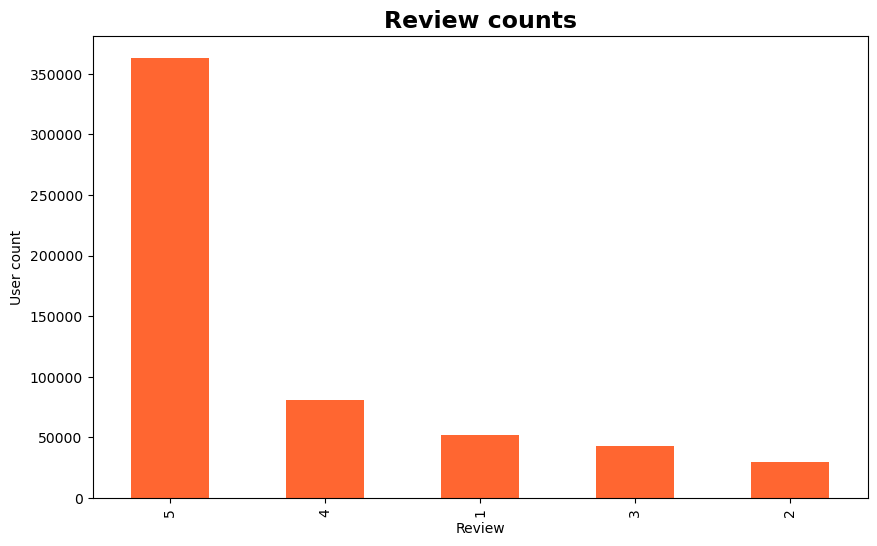

In [21]:
ratings.Score.apply(lambda x: int(np.ceil(x))).value_counts().plot.bar(
    figsize=(10, 6), color="#FF6631"
)
plt.title("Review counts", fontweight="bold", fontsize=17)
plt.xlabel("Review")
plt.ylabel("User count")
plt.show()

In [23]:
ratings["Time"] = ratings["Time"].map(lambda x: datetime.fromtimestamp(x))

In [24]:
ratings.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27 01:00:00,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07 01:00:00,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18 01:00:00,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13 01:00:00,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21 01:00:00,Great taffy,Great taffy at a great price. There was a wid...


In [30]:
ratings["Time"].describe()

count                           568454
mean     2011-01-29 00:16:44.902420224
min                1999-10-08 01:00:00
25%                2010-04-15 01:00:00
50%                2011-07-20 01:00:00
75%                2012-03-26 01:00:00
max                2012-10-26 01:00:00
Name: Time, dtype: object

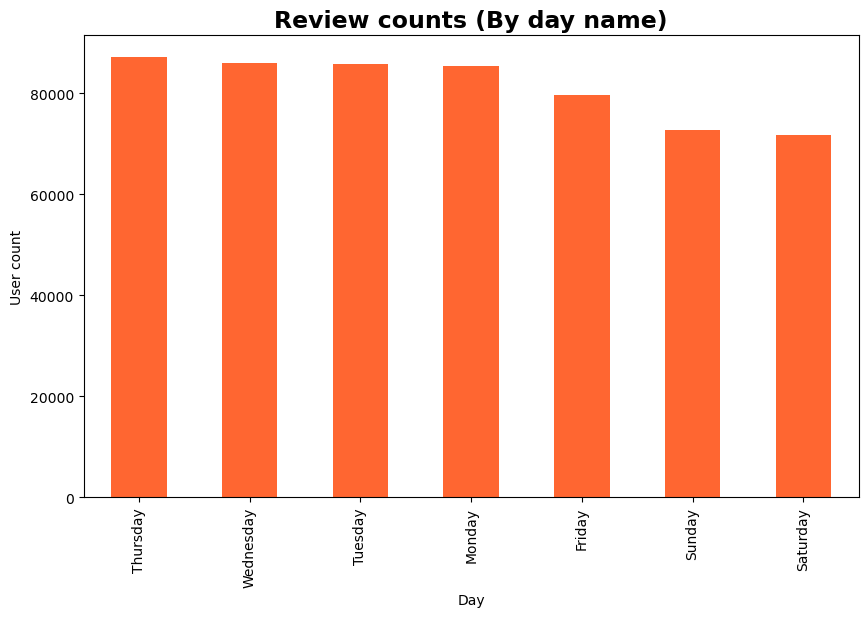

In [31]:
ratings["Time"].dt.day_name().value_counts().plot.bar(color="#FF6631", figsize=(10, 6))
plt.title("Review counts (By day name)", fontweight="bold", fontsize=17)
plt.xlabel("Day")
plt.ylabel("User count")
plt.show()

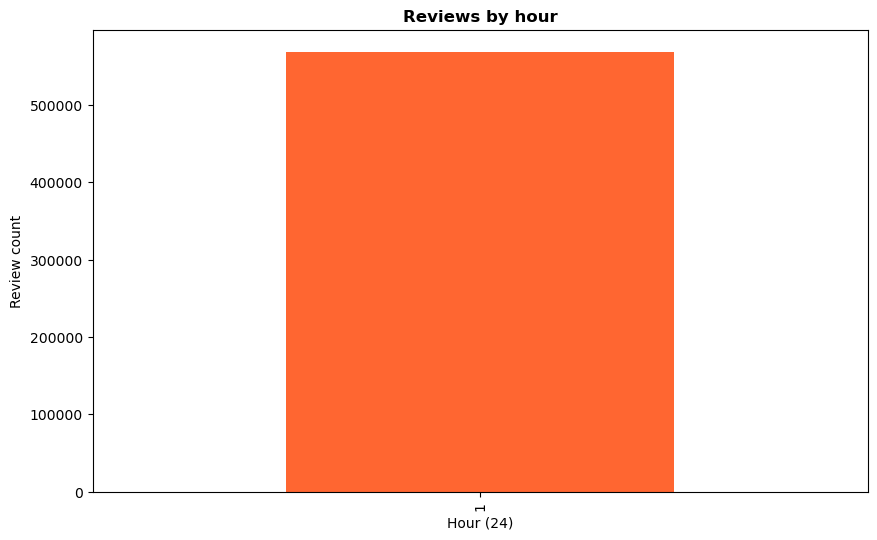

In [33]:
ratings.Time.dt.hour.value_counts().plot.bar(figsize=(10, 6), color="#FF6631")
plt.xlabel("Hour (24)")
plt.ylabel("Review count")
plt.title("Reviews by hour", fontweight="bold")
plt.show()

In [151]:
prod_rating = ratings.groupby("ProductId").filter(lambda x: x["Score"].count() >= 50)

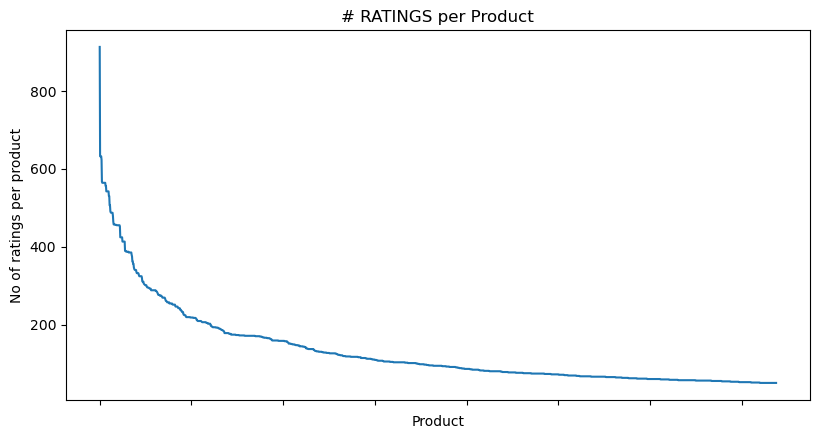

In [152]:
no_of_ratings_per_product = (
    prod_rating.groupby(by="ProductId")["Score"].count().sort_values(ascending=False)
)

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title("# RATINGS per Product")
plt.xlabel("Product")
plt.ylabel("No of ratings per product")
ax.set_xticklabels([])

plt.show()

In [200]:
list(
    prod_rating.groupby("ProductId")["Score"]
    .mean()
    .sort_values(ascending=False)
    .head()
    .to_dict()
    .keys()
)

['B000ED9L9E', 'B000O5DI1E', 'B001E6GFKI', 'B000NMJWZO', 'B0044MTGHI']

In [34]:
def get_feature_by_user(df):
    res = list()
    for i, v in tqdm(df.groupby("UserId")):
        res.append(
            (
                i,
                len(v["ProductId"]),
                (v["Score"] == 5).sum(),
                (v["Score"] == 4).sum(),
                (v["Score"] == 3).sum(),
                (v["Score"] == 2).sum(),
                (v["Score"] == 1).sum(),
                (v["Time"].dt.dayofweek == 0).sum(),
                (v["Time"].dt.dayofweek == 1).sum(),
                (v["Time"].dt.dayofweek == 2).sum(),
                (v["Time"].dt.dayofweek == 3).sum(),
                (v["Time"].dt.dayofweek == 4).sum(),
                (v["Time"].dt.dayofweek == 5).sum(),
                (v["Time"].dt.dayofweek == 6).sum(),
                (v["Time"].dt.hour > 17).sum(),
            )
        )

    res = pd.DataFrame(
        res,
        columns=[
            "UserId",
            "revised_products",
            "5_star_ratings_gave",
            "4_star_ratings_gave",
            "3_star_ratings_gave",
            "2_star_ratings_gave",
            "1_star_ratings_gave",
            "monday_review_count_user",
            "tuesday_review_count_user",
            "wednesday_review_count_user",
            "thursday_review_count_user",
            "friday_review_count_user",
            "saturday_review_count_user",
            "sunday_review_count_user",
            "evening_reviews_by_user",
        ],
    )
    return res

In [35]:
def get_feature_by_product(df):
    res = list()
    for i, v in tqdm(df.groupby("ProductId")):
        res.append(
            (
                i,
                len(v["UserId"]),
                (v["Score"] == 5).sum(),
                (v["Score"] == 4).sum(),
                (v["Score"] == 3).sum(),
                (v["Score"] == 2).sum(),
                (v["Score"] == 1).sum(),
                (v["Time"].dt.dayofweek == 0).sum(),
                (v["Time"].dt.dayofweek == 1).sum(),
                (v["Time"].dt.dayofweek == 2).sum(),
                (v["Time"].dt.dayofweek == 3).sum(),
                (v["Time"].dt.dayofweek == 4).sum(),
                (v["Time"].dt.dayofweek == 5).sum(),
                (v["Time"].dt.dayofweek == 6).sum(),
                (v["Time"].dt.hour > 17).sum(),
            )
        )

    res = pd.DataFrame(
        res,
        columns=[
            "ProductId",
            "user_count",
            "1_star_ratings_recieved",
            "2_star_ratings_recieved",
            "3_star_ratings_recieved",
            "4_star_ratings_recieved",
            "5_star_ratings_recieved",
            "monday_review_count_item",
            "tuesday_review_count_item",
            "wednesday_review_count_item",
            "thursday_review_count_item",
            "friday_review_count_item",
            "saturday_review_count_item",
            "sunday_review_count_item",
            "evening_reviews_by_movie",
        ],
    )
    return res

In [36]:
start = min(ratings["Time"])
end = max(ratings["Time"])
interval = end - start

ratings["Score"] = ratings["Score"].apply(lambda x: int(np.ceil(x)))

train = ratings[ratings["Time"] <= (end - interval / 3)]
test = ratings[ratings["Time"] >= (start + interval / 3)]

train_y = train[train["Time"] >= (start + interval / 3)]
train_X = train[train["Time"] < (start + interval / 3)]
test_y = test[test["Time"] >= (end - interval / 3)]
test_X = test[test["Time"] < (end - interval / 3)]

train_tgt_user = set(train_X["UserId"]) & set(train_y["UserId"])
test_tgt_user = set(test_X["UserId"]) & set(test_y["UserId"])

f"""train_X.shape: {train_X.shape} test_X.shape: {test_X.shape}"""

'train_X.shape: (311, 10) test_X.shape: (45529, 10)'

In [38]:
test.Time.min(), test.Time.max()

(Timestamp('2004-02-15 01:00:00'), Timestamp('2012-10-26 01:00:00'))

In [39]:
train.Time.min(), train.Time.max()

(Timestamp('1999-10-08 01:00:00'), Timestamp('2008-06-20 01:00:00'))

In [40]:
train_X_u = get_feature_by_user(train_X)
test_X_u = get_feature_by_user(test_X)

train_X_p = get_feature_by_product(train_X)
test_X_p = get_feature_by_product(test_X)

  0%|          | 0/176 [00:00<?, ?it/s]

100%|██████████| 12404/12404 [00:56<00:00, 220.00it/s]


In [206]:
def get_model_input(X_u, X_m, y, tgt_users):

    merged = pd.merge(X_u, y, on=["UserId"], how="inner")
    merged = pd.merge(X_m, merged, on=["ProductId"], how="outer")
    merged = merged.query("UserId in @tgt_users")
    # print(merged.columns)

    merged.fillna(0, inplace=True)
    features_cols = list(
        merged.drop(columns=["UserId", "ProductId", "Score", "Time"]).columns
    )
    print(features_cols)
    query_list = merged["UserId"].value_counts()

    merged = merged.set_index(["UserId", "ProductId"])

    query_list = query_list.sort_index()

    merged.sort_index(inplace=True)

    df_x = merged[features_cols]

    df_y = merged["Score"]

    return df_x, df_y, query_list


X_train, y_train, query_list_train = get_model_input(
    train_X_u, train_X_p, train_y, train_tgt_user
)
X_test, y_test, query_list_test = get_model_input(
    test_X_u, test_X_p, test_y, test_tgt_user
)

C:\Users\ologa\AppData\Local\Temp\ipykernel_33740\2586503965.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged.fillna(0, inplace=True)


['user_count', '1_star_ratings_recieved', '2_star_ratings_recieved', '3_star_ratings_recieved', '4_star_ratings_recieved', '5_star_ratings_recieved', 'monday_review_count_item', 'tuesday_review_count_item', 'wednesday_review_count_item', 'thursday_review_count_item', 'friday_review_count_item', 'saturday_review_count_item', 'sunday_review_count_item', 'evening_reviews_by_movie', 'revised_products', '5_star_ratings_gave', '4_star_ratings_gave', '3_star_ratings_gave', '2_star_ratings_gave', '1_star_ratings_gave', 'monday_review_count_user', 'tuesday_review_count_user', 'wednesday_review_count_user', 'thursday_review_count_user', 'friday_review_count_user', 'saturday_review_count_user', 'sunday_review_count_user', 'evening_reviews_by_user', 'Id', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Summary', 'Text']
['user_count', '1_star_ratings_recieved', '2_star_ratings_recieved', '3_star_ratings_recieved', '4_star_ratings_recieved', '5_star_ratings_recieved', 'monday_revi

C:\Users\ologa\AppData\Local\Temp\ipykernel_33740\2586503965.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged.fillna(0, inplace=True)


In [202]:
X_train.user_count.value_counts()

user_count
0.0     237
1.0      10
34.0      2
36.0      1
Name: count, dtype: int64

In [91]:
num_cols = [
    "user_count",
    "1_star_ratings_recieved",
    "2_star_ratings_recieved",
    "3_star_ratings_recieved",
    "4_star_ratings_recieved",
    "5_star_ratings_recieved",
    "monday_review_count_item",
    "tuesday_review_count_item",
    "wednesday_review_count_item",
    "thursday_review_count_item",
    "friday_review_count_item",
    "saturday_review_count_item",
    "sunday_review_count_item",
    "evening_reviews_by_movie",
    "revised_products",
    "5_star_ratings_gave",
    "4_star_ratings_gave",
    "3_star_ratings_gave",
    "2_star_ratings_gave",
    "1_star_ratings_gave",
    "monday_review_count_user",
    "tuesday_review_count_user",
    "wednesday_review_count_user",
    "thursday_review_count_user",
    "friday_review_count_user",
    "saturday_review_count_user",
    "sunday_review_count_user",
    "evening_reviews_by_user",
]  # 'HelpfulnessNumerator',
#'HelpfulnessDenominator',]

cat_cols = ["Id", "ProfileName", "Summary", "Text"]

In [92]:
dtrain = xgb.DMatrix(X_train[num_cols], label=y_train)
dval = xgb.DMatrix(X_test[num_cols], label=y_test)

In [93]:
watchlist = [(dtrain, "train"), (dval, "val")]

In [94]:
xgb_params = {
    "eta": 0.1,
    # 'max_depth': 6,
    # 'min_child_weight': 1,
    "objective": "rank:ndcg",
    "eval_metric": "ndcg",
    "n_estimators": 100,
    # 'nthread': 8,
    # 'seed': 1,
    "verbosity": 1,
}

In [108]:
model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=200,
    # group=query_list_train,
    verbose_eval=5,
    # eval_group=[list(query_list_test)],
    evals=watchlist,
)

[10:27:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	train-ndcg:0.99204	val-ndcg:0.96000
[5]	train-ndcg:0.99204	val-ndcg:0.96000


[10]	train-ndcg:0.99204	val-ndcg:0.96000
[15]	train-ndcg:0.99204	val-ndcg:0.96000
[20]	train-ndcg:0.99204	val-ndcg:0.96000
[25]	train-ndcg:0.99204	val-ndcg:0.96000
[30]	train-ndcg:0.99204	val-ndcg:0.96000
[35]	train-ndcg:0.99204	val-ndcg:0.96000
[40]	train-ndcg:0.99204	val-ndcg:0.96000
[45]	train-ndcg:0.99204	val-ndcg:0.96000
[50]	train-ndcg:0.99204	val-ndcg:0.96000
[55]	train-ndcg:0.99204	val-ndcg:0.96000
[60]	train-ndcg:0.99204	val-ndcg:0.96000
[65]	train-ndcg:0.99204	val-ndcg:0.96000
[70]	train-ndcg:0.99204	val-ndcg:0.96000
[75]	train-ndcg:0.99204	val-ndcg:0.96000
[80]	train-ndcg:0.99204	val-ndcg:0.96000
[85]	train-ndcg:0.99204	val-ndcg:0.96000
[90]	train-ndcg:0.99204	val-ndcg:0.96000
[95]	train-ndcg:0.99204	val-ndcg:0.96000
[100]	train-ndcg:0.99204	val-ndcg:0.96000
[105]	train-ndcg:0.99204	val-ndcg:0.96000
[110]	train-ndcg:0.99204	val-ndcg:0.96000
[115]	train-ndcg:0.99204	val-ndcg:0.96000
[120]	train-ndcg:0.99204	val-ndcg:0.96000
[125]	train-ndcg:0.99204	val-ndcg:0.96000
[130]	trai

In [135]:
ranker = xgb.XGBRanker(
    tree_method="hist",
    lambdarank_num_pair_per_sample=8,
    objective="rank:ndcg",
    lambdarank_pair_method="topk",
    enable_categorical=True,
)
ranker.fit(
    X_train[num_cols],
    y_train,
    group=query_list_train,
    eval_metric="ndcg",
    eval_set=[(X_test[num_cols], y_test)],
    eval_group=[list(query_list_test)],
    verbose=10,
)

[12:34:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "lambdarank_num_pair_per_sample", "lambdarank_pair_method" } are not used.

[0]	validation_0-ndcg:0.95386


c:\Users\ologa\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-ndcg:0.95386
[20]	validation_0-ndcg:0.95386
[30]	validation_0-ndcg:0.95386
[40]	validation_0-ndcg:0.95386
[50]	validation_0-ndcg:0.95386
[60]	validation_0-ndcg:0.95386
[70]	validation_0-ndcg:0.95386
[80]	validation_0-ndcg:0.95386
[90]	validation_0-ndcg:0.95386
[99]	validation_0-ndcg:0.95386


XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None,
          early_stopping_rounds=None, enable_categorical=True, eval_metric=None,
          feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          lambdarank_num_pair_per_sample=8, lambdarank_pair_method='topk',
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, n_estimators=100, n_jobs=None,
          num_parallel_tree=None, ...)

In [105]:
query_list_train.shape

(16,)

In [106]:
len(np.unique(X_train.index.get_level_values(0).values))

16

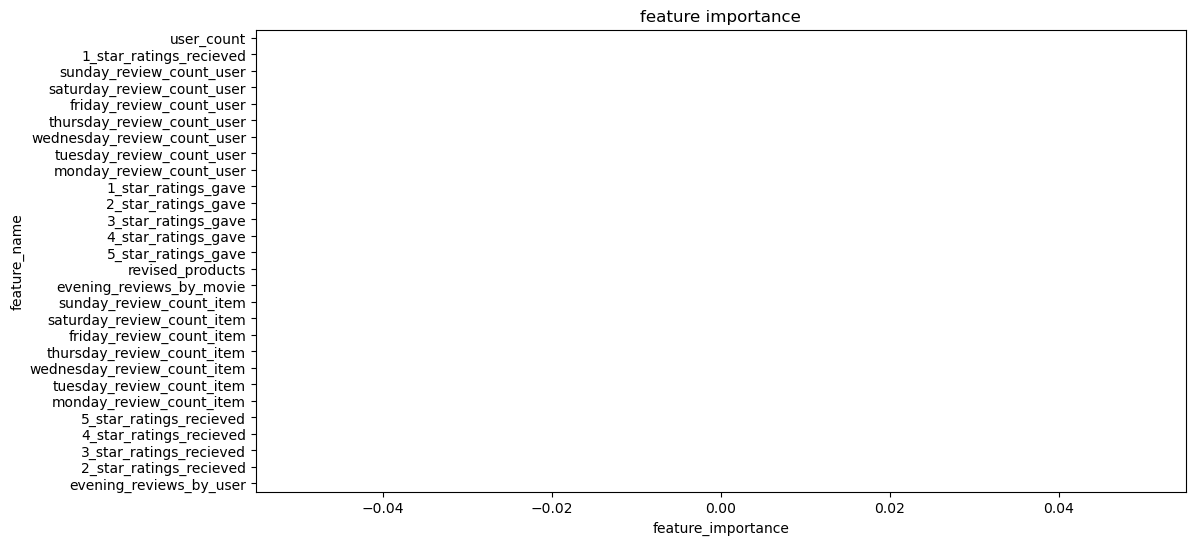

In [137]:
plt.figure(figsize=(12, 6))
df_plt = pd.DataFrame(
    {
        "feature_name": X_train[num_cols].columns,
        "feature_importance": ranker.feature_importances_,
    }
)
df_plt.sort_values("feature_importance", ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt, color="#FF6631")
plt.title("feature importance")
plt.show()

In [147]:
ranker.get_booster().get_score(importance_type="cover")

{}

In [173]:
def predict_at_k(data, model, k):
    user_ids = list()
    product_ids = list()
    ranks = list()

    for userId, df in data.groupby("UserId"):
        # if userId == "A1004703RC79J9":
        pred = ranker.predict(df.loc[userId])
        prodId = np.array(df.reset_index()["ProductId"])
        topK_index = np.argsort(pred)[::-1][:k]
        product_ids.extend(list(prodId[topK_index]))
        user_ids.extend([userId] * len(topK_index))
        ranks.extend(list(range(1, len(topK_index) + 1)))

    results = pd.DataFrame(
        {"userId": user_ids, "productId": product_ids, "rank": ranks}
    )

    return results


predicted = predict_at_k(X_test[num_cols], model, 5)

In [191]:
X_test[num_cols].loc["A1004703RC79J9"]

,user_count,1_star_ratings_recieved,2_star_ratings_recieved,3_star_ratings_recieved,4_star_ratings_recieved,5_star_ratings_recieved,monday_review_count_item,tuesday_review_count_item,wednesday_review_count_item,thursday_review_count_item,...,2_star_ratings_gave,1_star_ratings_gave,monday_review_count_user,tuesday_review_count_user,wednesday_review_count_user,thursday_review_count_user,friday_review_count_user,saturday_review_count_user,sunday_review_count_user,evening_reviews_by_user
ProductId,,,,,,,,,,,,,,,,,,,,,
B001OCKIP0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
B002TMV34E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
B003GTR8IO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
B003XDH6M6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
B004OV6X6Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
B0090X8IPM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [196]:
predicted.columns

Index(['userId', 'productId', 'rank'], dtype='object')

In [175]:
predicted.to_parquet("./recommendations.parquet", index=True)

In [150]:
# predicted.query('userId == A1004703RC79J9')

predicted[predicted.userId == "A1004703RC79J9"]

predicted[predicted.userId == "A1004703RC7"]

,userId,productId,rank


In [203]:
import random

sample = random.choice(predicted.userId)
print(sample)
print("[predicted]")
# print(predicted.query(f'userId == {sample}')[['productId', 'rank']])
print(predicted[predicted.userId == sample][["productId", "rank"]])
print("+" * 20)
print("[actual]")
print(y_test[sample].sort_values(ascending=False))

A37I6B2ZCDFIQX
[predicted]
       productId  rank
8496  B001IZM8WY     1
++++++++++++++++++++
[actual]
ProductId
B001IZM8WY    5.0
Name: Score, dtype: float64


In [142]:
def coverage(preds, train_X_p):
    test_recs = preds["productId"].nunique()
    train_movies = train_X_p["ProductId"].nunique()

    return test_recs / train_movies

In [143]:
coverage(predicted, train_X_p)

57.6

In [171]:
ranker.save_model("./ranker.bin")

In [180]:
# calculate file size in KB, MB, GB
def convert_bytes(size):
    """Convert bytes to KB, or MB or GB"""
    for x in ["bytes", "KB", "MB", "GB", "TB"]:
        if size < 1024.0:
            return "%3.1f %s" % (size, x)
        size /= 1024.0

In [183]:
import os.path

# file to check
file_path = r"./ranker.bin"

sz = os.path.getsize(file_path)
x = convert_bytes(sz)
print(f"The {file_path} size is", x)

The ./ranker.bin size is 21.9 KB


In [194]:
import os.path

# file to check
file_path = r"./amazonproducts.parquet"

sz = os.path.getsize(file_path)
x = convert_bytes(sz)
print(f"The {file_path} size is", x)

The ./amazonproducts.parquet size is 172.8 MB


In [195]:
import os.path

# file to check
file_path = r"./reviews.csv"

sz = os.path.getsize(file_path)
x = convert_bytes(sz)
print(f"The {file_path} size is", x)

The ./reviews.csv size is 287.0 MB
